# Predicting Water Levels for the Auser Aquifer

## Importing libraries and dataset

In [1]:
import pandas as pd 
from datetime import datetime
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error

In [2]:
aus = pd.read_csv('Aquifer_Auser.csv')

## Performing the same initial transformations as the first notebook

In [3]:
aus['Date'] = pd.to_datetime(aus['Date'], format='%d/%m/%Y')

In [4]:
abs_cols = ['Depth_to_Groundwater_LT2', 'Depth_to_Groundwater_SAL', 'Depth_to_Groundwater_PAG', 'Depth_to_Groundwater_CoS', 'Depth_to_Groundwater_DIEC',
           'Volume_POL', 'Volume_CC1', 'Volume_CC2', 'Volume_CSA', 'Volume_CSAL']
# absolute values can be taken from the above columns as clarified by competition host in a discussion thread on kaggle

In [5]:
for col in abs_cols:
    aus[col] = abs(aus[col])

## SARIMA models for Depths of SAL, CoS and LT2

### SAL

In [6]:
aus_sal = aus[['Date', 'Depth_to_Groundwater_SAL']]

#### Data Cleaning

In [7]:
aus_sal.loc[aus_sal['Depth_to_Groundwater_SAL'].notnull()].head()

,Date,Depth_to_Groundwater_SAL
3319,2007-04-06,6.69
3320,2007-04-07,6.71
3321,2007-04-08,6.67
3322,2007-04-09,6.62
3323,2007-04-10,6.64


In [8]:
aus_sal = aus_sal[3319:]

In [9]:
aus_sal['Depth_to_Groundwater_SAL'] = aus_sal['Depth_to_Groundwater_SAL'].replace(0, np.nan)

In [10]:
aus_sal['Depth_to_Groundwater_SAL'] = aus_sal['Depth_to_Groundwater_SAL'].interpolate()

In [11]:
aus_sal.isnull().sum()

Date                        0
Depth_to_Groundwater_SAL    0
dtype: int64

In [13]:
aus_sal.set_index('Date', inplace=True)

In [15]:
aus_sal = aus_sal.resample('W').mean()

#### Train Test Split

In [16]:
len(aus_sal)

692

In [17]:
len(aus_sal)*0.8

553.6

In [18]:
aus_sal_train = aus_sal[:553]
aus_sal_train.tail()

,Depth_to_Groundwater_SAL
Date,
2017-10-08,5.902857
2017-10-15,5.940000
2017-10-22,5.988571
2017-10-29,6.010000
2017-11-05,6.072857


In [19]:
aus_sal_test = aus_sal[553:]
aus_sal_test.head()

,Depth_to_Groundwater_SAL
Date,
2017-11-12,5.992857
2017-11-19,5.967143
2017-11-26,6.028571
2017-12-03,5.978571
2017-12-10,5.935714


In [20]:
aus_sal_train.index = pd.DatetimeIndex(aus_sal_train.index).to_period('W')
aus_sal_test.index = pd.DatetimeIndex(aus_sal_test.index).to_period('W')

#### Augmented Dickey-Fuller test to check for Stationarity

In [6]:
def interpret_df(df):
    dfoutput = pd.Series(df[0:2], index=['Test Statistic','p-value'])
    return dfoutput

In [22]:
interpret_df(adfuller(aus_sal_train['Depth_to_Groundwater_SAL']))

Test Statistic   -4.089970
p-value           0.001006
dtype: float64

With a p-value of 0.001006, the stationarity condition is fulfilled and differencing is not required.

#### Checking for AR and MA lags

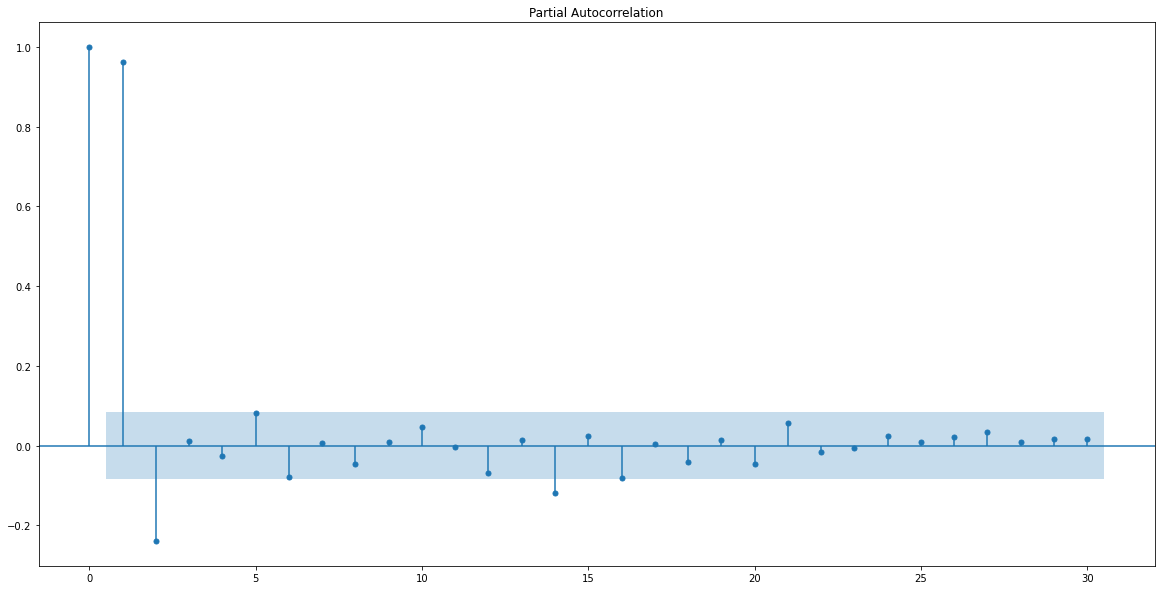

In [23]:
fig, ax = plt.subplots(figsize=(20, 10))
plot_pacf(aus_sal_train['Depth_to_Groundwater_SAL'], lags=30, ax=ax)
plt.show()

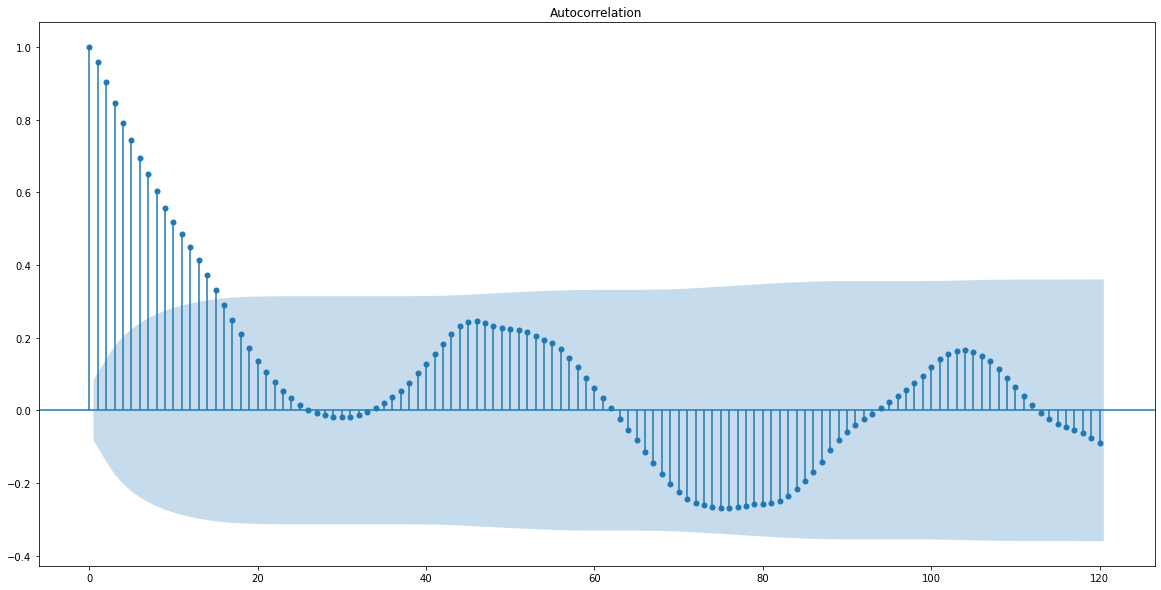

In [26]:
fig, ax = plt.subplots(figsize=(20, 10))
plot_acf(aus_sal_train['Depth_to_Groundwater_SAL'], lags=120, ax=ax)
plt.show()

The PACF curve shows a sharp cut-off at the 2nd lag while the ACF curve shows a gradual decay. 

Since Stationarity has been fulfilled as shown earlier, the (p, d, q) will be set as (2, 0, 0)

The length of season will be set to a year, or in this case, 52 weeks. This trend can roughly be seen from the ACF plot as well.

#### Gridsearching seasonal_order parameters for SARIMA model

In [33]:
# Starting MSE and (P, D, Q).
final_p = 0
final_d = 0
final_q = 0

mse = 10**16

for P in range(3):
    for Q in range(3):
        for D in range(3):
            try:
                # Instantiate SARIMA model.
                sarima = SARIMAX(endog = aus_sal_train['Depth_to_Groundwater_SAL'],
                                 order = (2, 0, 0),              # (p, d, q)
                                 seasonal_order = (P, D, Q, 52)) # (P, D, Q, S)

                # Fit SARIMA model.
                model = sarima.fit()

                # Generate predictions based on training set.
                # Start at time period 0 and end at 552.
                preds = model.predict(start=0, end=552)

                # Evaluate predictions.
                print(f'The MSE for (2, 0, 0)x({P},{D},{Q},52) is: {mean_squared_error(aus_sal_train["Depth_to_Groundwater_SAL"], preds)}')
                
                # Save for final report.
                if mse > mean_squared_error(aus_sal_train['Depth_to_Groundwater_SAL'], preds):
                    
                    mse =  mean_squared_error(aus_sal_train['Depth_to_Groundwater_SAL'], preds)
                    final_P = P
                    final_D = D
                    final_Q = Q

                
            except:
                pass

print(f'Our model that minimizes MSE on the training data is the SARIMA(2, 0, 0)x({final_P},{final_D},{final_Q},52).')
print(f'This model has an MSE of {mse}.')

The MSE for (2, 0, 0)x(0,0,0,52) is: 0.10634743966609117
The MSE for (2, 0, 0)x(0,1,0,52) is: 4.161877706680601
The MSE for (2, 0, 0)x(0,2,0,52) is: 5.898068112157095
The MSE for (2, 0, 0)x(0,0,1,52) is: 0.10629463152204574
The MSE for (2, 0, 0)x(0,1,1,52) is: 4.147059226476444
The MSE for (2, 0, 0)x(0,2,1,52) is: 5.838463352682519


C:\Users\jonat\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


The MSE for (2, 0, 0)x(0,0,2,52) is: 0.10609057792666837
The MSE for (2, 0, 0)x(0,1,2,52) is: 4.147030403877382


C:\Users\jonat\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


The MSE for (2, 0, 0)x(0,2,2,52) is: 5.830982359284344
The MSE for (2, 0, 0)x(1,0,0,52) is: 0.10628533911594472
The MSE for (2, 0, 0)x(1,1,0,52) is: 4.150952506677218
The MSE for (2, 0, 0)x(1,2,0,52) is: 5.847526499278063
The MSE for (2, 0, 0)x(1,0,1,52) is: 0.10629038904679959
The MSE for (2, 0, 0)x(1,1,1,52) is: 4.147020119451283


C:\Users\jonat\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


The MSE for (2, 0, 0)x(1,2,1,52) is: 5.831580010641998
The MSE for (2, 0, 0)x(1,0,2,52) is: 0.10626876960687906


C:\Users\jonat\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


The MSE for (2, 0, 0)x(1,1,2,52) is: 4.147001296487007


C:\Users\jonat\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


The MSE for (2, 0, 0)x(1,2,2,52) is: 5.8309650464036675
The MSE for (2, 0, 0)x(2,0,0,52) is: 0.10609869443773905
The MSE for (2, 0, 0)x(2,1,0,52) is: 4.149623835709822
The MSE for (2, 0, 0)x(2,2,0,52) is: 5.839179173254335


C:\Users\jonat\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:994: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\jonat\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


The MSE for (2, 0, 0)x(2,0,1,52) is: 0.10599726522298412


C:\Users\jonat\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


The MSE for (2, 0, 0)x(2,1,1,52) is: 4.146842835083072


C:\Users\jonat\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


The MSE for (2, 0, 0)x(2,2,1,52) is: 5.831191701251342


C:\Users\jonat\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


The MSE for (2, 0, 0)x(2,0,2,52) is: 0.10621045112184163
The MSE for (2, 0, 0)x(2,1,2,52) is: 4.146775097417508


C:\Users\jonat\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


The MSE for (2, 0, 0)x(2,2,2,52) is: 5.8308037279106815
Our model that minimizes MSE on the training data is the SARIMA(2, 0, 0)x(2,0,1,52).
This model has an MSE of 0.10599726522298412.


#### Fitting Sarima model, generating predictions and computing RMSE

In [34]:
sarima = SARIMAX(endog = aus_sal_train['Depth_to_Groundwater_SAL'],
                order = (2, 0, 0),
                seasonal_order = (2, 0, 1, 52))

In [35]:
model = sarima.fit()

C:\Users\jonat\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:994: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\jonat\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


In [36]:
preds = model.predict(start=553, end=691)

In [37]:
print(np.sqrt(mean_squared_error(aus_sal_test['Depth_to_Groundwater_SAL'], preds)))

0.6179366910398301


### Repeating the same for Depths of CoS

In [47]:
aus_cos = aus[['Date', 'Depth_to_Groundwater_CoS']]
aus_cos.loc[aus_cos['Depth_to_Groundwater_CoS'].notnull()].head()

,Date,Depth_to_Groundwater_CoS
3038,2006-06-29,6.43
3039,2006-06-30,6.46
3040,2006-07-01,6.50
3041,2006-07-02,6.55
3042,2006-07-03,6.60


In [48]:
aus_cos = aus_cos[3038:]
aus_cos['Depth_to_Groundwater_CoS'] = aus_cos['Depth_to_Groundwater_CoS'].replace(0, np.nan)
aus_cos['Depth_to_Groundwater_CoS'] = aus_cos['Depth_to_Groundwater_CoS'].interpolate()
aus_cos.isnull().sum()

Date                        0
Depth_to_Groundwater_CoS    0
dtype: int64

In [49]:
aus_cos.set_index('Date', inplace=True)
aus_cos = aus_cos.resample('W').mean()

In [50]:
len(aus_cos)

732

In [51]:
len(aus_cos)*0.8

585.6

In [53]:
aus_cos_train = aus_cos[:585]
aus_cos_train.tail()

,Depth_to_Groundwater_CoS
Date,
2017-08-13,7.928571
2017-08-20,7.725714
2017-08-27,8.128571
2017-09-03,8.495714
2017-09-10,8.428571


In [54]:
aus_cos_test = aus_cos[585:]
aus_cos_test.head()

,Depth_to_Groundwater_CoS
Date,
2017-09-17,7.705714
2017-09-24,7.414286
2017-10-01,7.271429
2017-10-08,7.197143
2017-10-15,7.152857


In [55]:
aus_cos_train.index = pd.DatetimeIndex(aus_cos_train.index).to_period('W')
aus_cos_test.index = pd.DatetimeIndex(aus_cos_test.index).to_period('W')

In [57]:
interpret_df(adfuller(aus_cos_train['Depth_to_Groundwater_CoS']))

Test Statistic   -6.362635e+00
p-value           2.453048e-08
dtype: float64

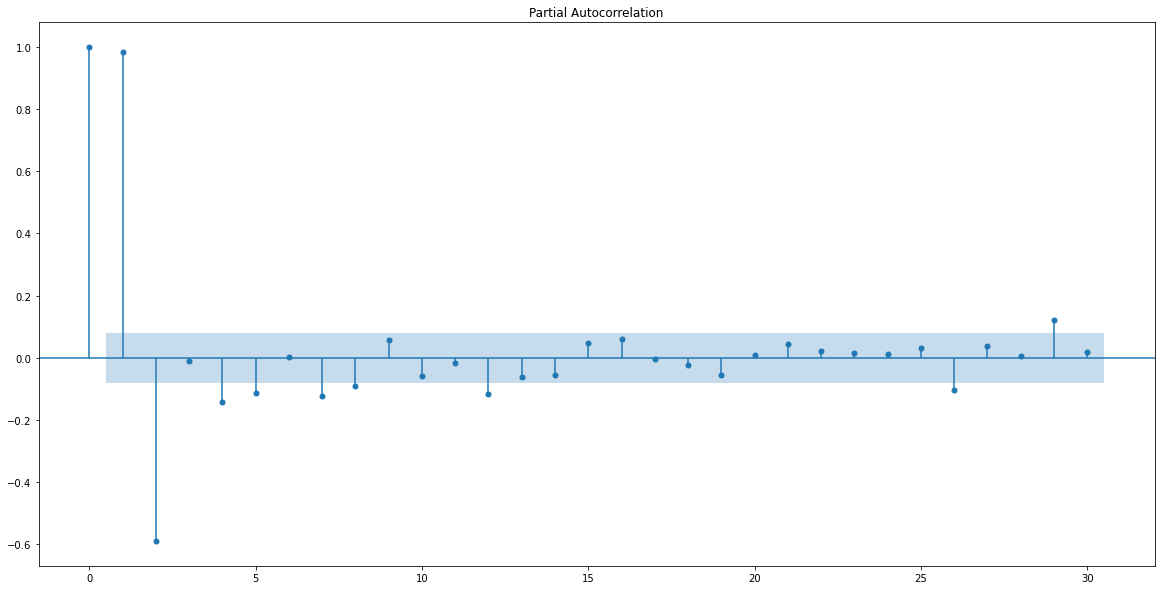

In [58]:
fig, ax = plt.subplots(figsize=(20, 10))
plot_pacf(aus_cos_train['Depth_to_Groundwater_CoS'], lags=30, ax=ax)
plt.show()

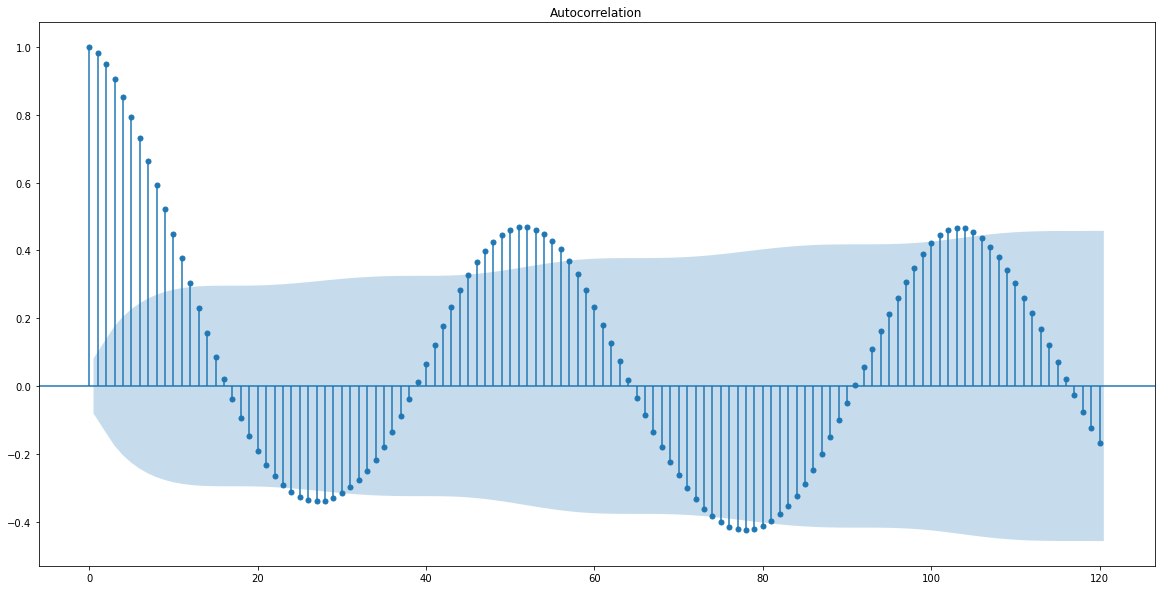

In [59]:
fig, ax = plt.subplots(figsize=(20, 10))
plot_acf(aus_cos_train['Depth_to_Groundwater_CoS'], lags=120, ax=ax)
plt.show()

The Depth to Groundwater for the CoS well shows similar trends when compared to the earlier SAL well: 

The PACF curve shows a sharp cut-off at the 2nd lag while the ACF curve shows a gradual decay.

Since Stationarity has been fulfilled as shown by a p-value of 2.45*(10^-8), the (p, d, q) will be set as (2, 0, 0)

The length of season will be set to a year, or in this case, 52 weeks. This trend can roughly be seen from the ACF plot as well.

In [61]:
# Starting MSE and (P, D, Q).
final_p = 0
final_d = 0
final_q = 0

mse = 10**16

for P in range(3):
    for Q in range(3):
        for D in range(3):
            try:
                # Instantiate SARIMA model.
                sarima = SARIMAX(endog = aus_cos_train['Depth_to_Groundwater_CoS'],
                                 order = (2, 0, 0),              # (p, d, q)
                                 seasonal_order = (P, D, Q, 52)) # (P, D, Q, S)

                # Fit SARIMA model.
                model = sarima.fit()

                # Generate predictions based on training set.
                # Start at time period 0 and end at 584.
                preds = model.predict(start=0, end=584)

                # Evaluate predictions.
                print(f'The MSE for (2, 0, 0)x({P},{D},{Q},52) is: {mean_squared_error(aus_cos_train["Depth_to_Groundwater_CoS"], preds)}')
                
                # Save for final report.
                if mse > mean_squared_error(aus_cos_train['Depth_to_Groundwater_CoS'], preds):
                    
                    mse =  mean_squared_error(aus_cos_train['Depth_to_Groundwater_CoS'], preds)
                    final_P = P
                    final_D = D
                    final_Q = Q

                
            except:
                pass

print(f'Our model that minimizes MSE on the training data is the SARIMA(2, 0, 0)x({final_P},{final_D},{final_Q},52).')
print(f'This model has an MSE of {mse}.')

The MSE for (2, 0, 0)x(0,0,0,52) is: 0.10633036701774726
The MSE for (2, 0, 0)x(0,1,0,52) is: 3.5674664492233976
The MSE for (2, 0, 0)x(0,2,0,52) is: 5.361919191714495
The MSE for (2, 0, 0)x(0,0,1,52) is: 0.10625512907300269
The MSE for (2, 0, 0)x(0,1,1,52) is: 3.546937677911294


C:\Users\jonat\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


The MSE for (2, 0, 0)x(0,2,1,52) is: 5.281977013949755
The MSE for (2, 0, 0)x(0,0,2,52) is: 0.11867627992387325
The MSE for (2, 0, 0)x(0,1,2,52) is: 3.5468146846910753


C:\Users\jonat\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


The MSE for (2, 0, 0)x(0,2,2,52) is: 5.267507163900413
The MSE for (2, 0, 0)x(1,0,0,52) is: 0.106233117794742
The MSE for (2, 0, 0)x(1,1,0,52) is: 3.5524669354614185
The MSE for (2, 0, 0)x(1,2,0,52) is: 5.293416842324239
The MSE for (2, 0, 0)x(1,0,1,52) is: 0.1052639906455007
The MSE for (2, 0, 0)x(1,1,1,52) is: 3.546799057907909
The MSE for (2, 0, 0)x(1,2,1,52) is: 5.269226339492363


C:\Users\jonat\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\jonat\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


The MSE for (2, 0, 0)x(1,0,2,52) is: 0.10516138247506022


C:\Users\jonat\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


The MSE for (2, 0, 0)x(1,1,2,52) is: 3.5467183957131967


C:\Users\jonat\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


The MSE for (2, 0, 0)x(1,2,2,52) is: 5.2673732715625174


C:\Users\jonat\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:994: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


The MSE for (2, 0, 0)x(2,0,0,52) is: 0.10554813042776753
The MSE for (2, 0, 0)x(2,1,0,52) is: 3.5498703400250764
The MSE for (2, 0, 0)x(2,2,0,52) is: 5.280079165875827


C:\Users\jonat\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:994: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


The MSE for (2, 0, 0)x(2,0,1,52) is: 0.10521077053259924
The MSE for (2, 0, 0)x(2,1,1,52) is: 3.5467274510146933
The MSE for (2, 0, 0)x(2,2,1,52) is: 5.268200155244274


C:\Users\jonat\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


The MSE for (2, 0, 0)x(2,0,2,52) is: 0.10510908743441932
The MSE for (2, 0, 0)x(2,1,2,52) is: 3.5467113362841585


C:\Users\jonat\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


The MSE for (2, 0, 0)x(2,2,2,52) is: 5.2671946485732715
Our model that minimizes MSE on the training data is the SARIMA(2, 0, 0)x(2,0,2,52).
This model has an MSE of 0.10510908743441932.


In [62]:
sarima = SARIMAX(endog = aus_cos_train['Depth_to_Groundwater_CoS'],
                order = (2, 0, 0),
                seasonal_order = (2, 0, 2, 52))

In [63]:
model = sarima.fit()

C:\Users\jonat\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


In [64]:
preds = model.predict(start=585, end=731)
print(np.sqrt(mean_squared_error(aus_cos_test['Depth_to_Groundwater_CoS'], preds)))

1.379393145705593


Use of SARIMA models yields RMSE that are close to the standard deviation of the Depths features indicating that they yield poor results.